In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2020],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46541 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 218 ms, sys: 19.4 ms, total: 237 ms
Wall time: 229 ms


# config_year.year 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2020,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

# Visualization 2020

In [8]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 11 ms, sys: 874 µs, total: 11.9 ms
Wall time: 11 ms


In [9]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed -8304 rows
dropped 04 columns
CPU times: user 150 ms, sys: 50.5 ms, total: 201 ms
Wall time: 1.47 s


In [10]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [11]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 1.19 s, sys: 425 ms, total: 1.61 s
Wall time: 7.95 s


In [12]:
nans

{}

In [13]:
zeros

{'num_bikes_available': 3.7200780714579116,
 'num_bikes_available_types.mechanical': 10.947011491612026,
 'num_bikes_available_types.ebike': 34.745553283545874,
 'num_docks_available': 0.9716343731840344,
 'is_installed': 0.015522390067015257,
 'is_renting': 0.6032157685068078,
 'is_returning': 0.5911116665050918,
 'is_charging_station': 0.0001681125278016093,
 'status': 99.41056945877293,
 'dayofweek': 14.430106936378934,
 'hour': 4.134531489998145,
 'ctx0': 0.9716343731840344,
 'ctx1': 0.9711580543552633,
 'ctx2': 0.9724469170684089,
 'ctx3': 0.973987948573257,
 'ctx4': 0.974828511212265}

In [14]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [15]:
uniques

{'station_id': 0        1
 1      301
 2      300
 3      299
 4       14
       ... 
 501    366
 502    452
 503    450
 504    465
 505    502
 Name: station_id, Length: 506, dtype: int64,
 'num_bikes_available': 0       28.625000
 1       34.666667
 2       24.000000
 3       24.100000
 4       15.375000
           ...    
 4570    12.416667
 4571    28.333333
 4572    22.227273
 4573     1.885714
 4574    13.888889
 Name: num_bikes_available, Length: 4575, dtype: float64,
 'num_bikes_available_types.mechanical': 0       28.625000
 1       34.666667
 2       23.000000
 3       15.000000
 4       27.875000
           ...    
 3903    13.114286
 3904    48.916667
 3905    12.277778
 3906     1.526316
 3907    52.083333
 Name: num_bikes_available_types.mechanical, Length: 3908, dtype: float64,
 'num_bikes_available_types.ebike': 0        0.000000
 1        1.000000
 2        1.100000
 3        0.375000
 4        0.625000
           ...    
 1736    19.083333
 1737     3.894737
 1738  

## 2020 station_id

In [16]:
%%time

print(stats.describe(data[config_year.year].station_id))
data[config_year.year].station_id.describe().compute()

DescribeResult(nobs=3569038, minmax=(1, 519), mean=248.99172522119406, variance=20697.33371120023, skewness=0.05407903517245369, kurtosis=-1.1147611385521619)
CPU times: user 494 ms, sys: 167 ms, total: 661 ms
Wall time: 3 s


count    3.569038e+06
mean     2.489917e+02
std      1.438657e+02
min      1.000000e+00
25%      1.270000e+02
50%      2.490000e+02
75%      3.690000e+02
max      5.190000e+02
Name: station_id, dtype: float64

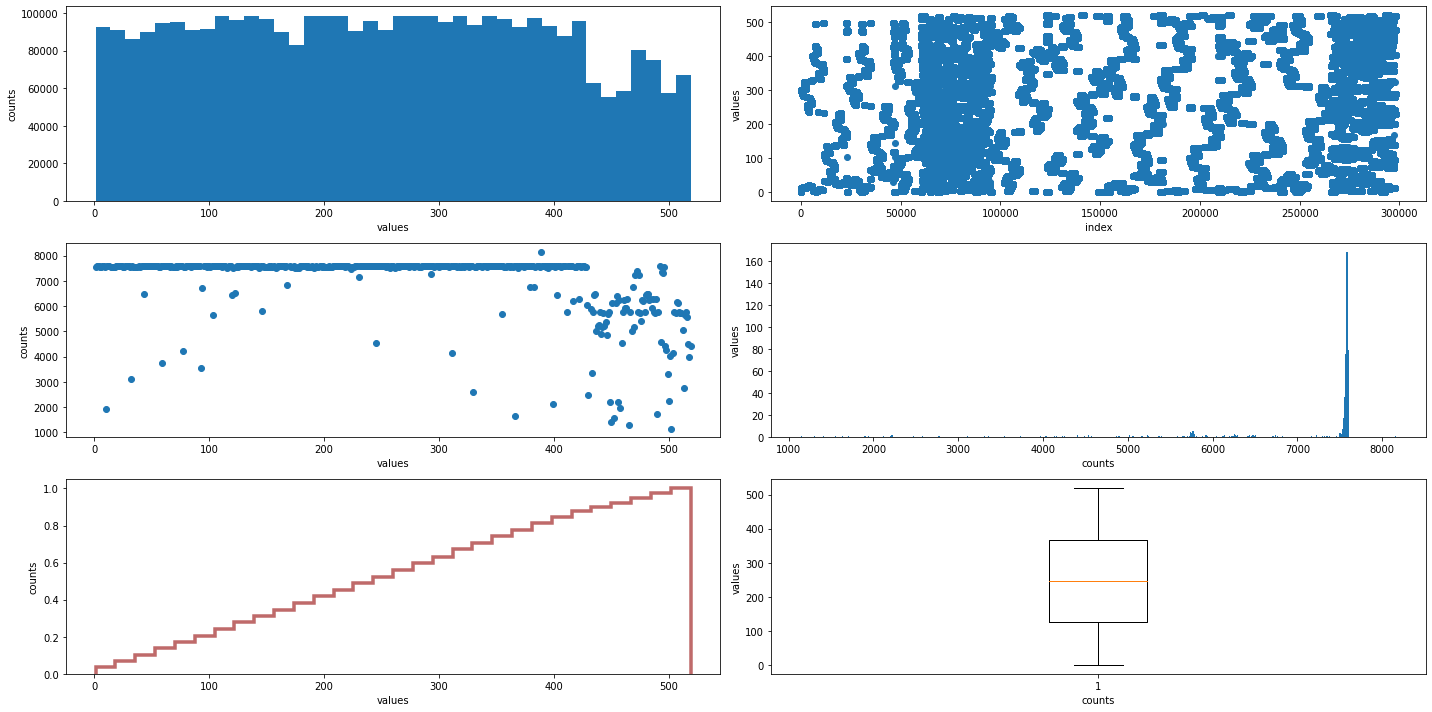

CPU times: user 7.65 s, sys: 1.44 s, total: 9.09 s
Wall time: 8.81 s


In [17]:
%%time

show_counts(data[config_year.year].station_id.compute())

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 2.83 s, sys: 103 ms, total: 2.94 s
Wall time: 17.4 s


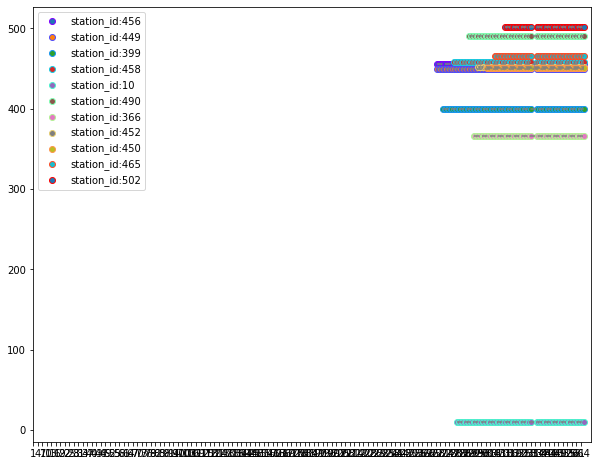

In [18]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 3.0),
    figsize=(10,8), 
    count=11
)



## 2020 num_bikes_available

In [19]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=3569038, minmax=(0.0, 54.0), mean=9.935109856125226, variance=64.79151486843952, skewness=0.8367063351161484, kurtosis=0.556102796208727)
CPU times: user 534 ms, sys: 112 ms, total: 646 ms
Wall time: 2.96 s


count    3.569038e+06
mean     9.935110e+00
std      8.049318e+00
min      0.000000e+00
25%      2.909091e+00
50%      8.777778e+00
75%      1.528571e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

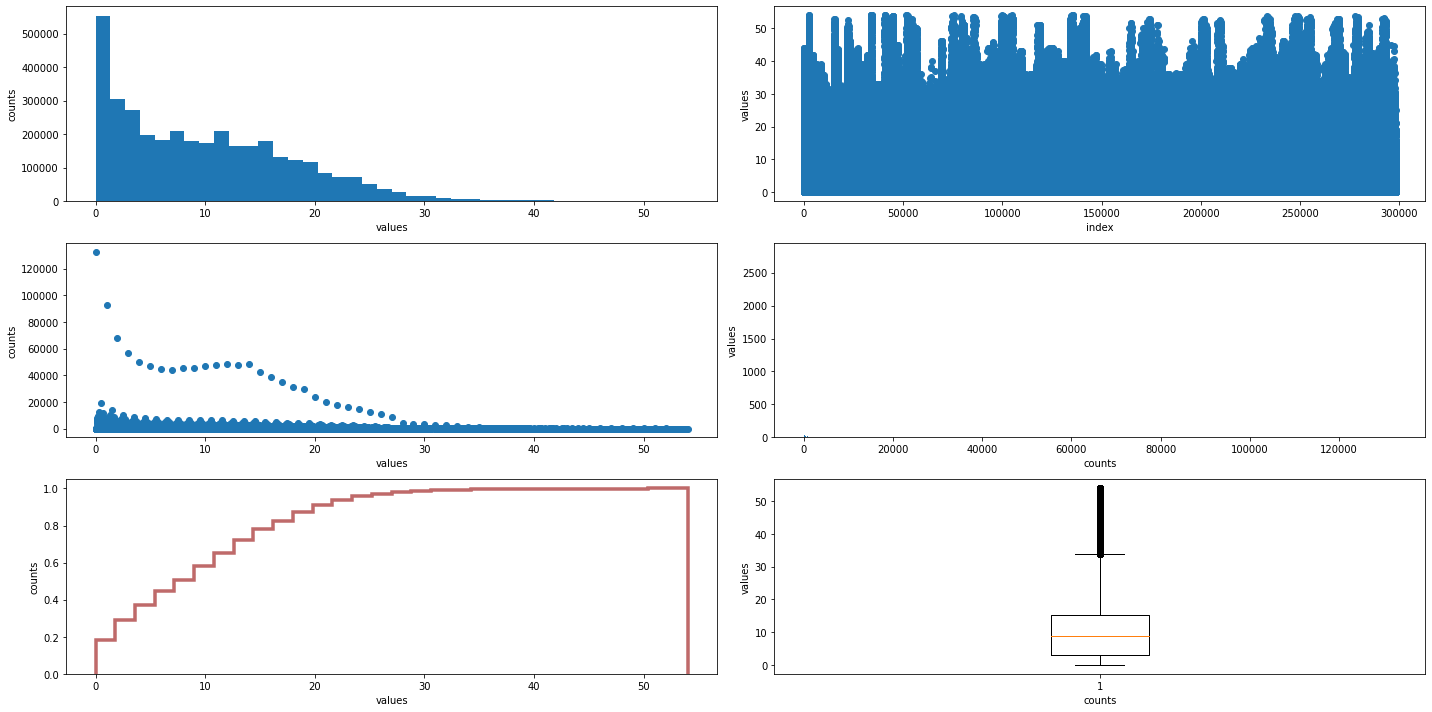

CPU times: user 14.5 s, sys: 1.22 s, total: 15.7 s
Wall time: 16.2 s


In [20]:
%%time

show_counts(data[config_year.year].num_bikes_available.compute())

327
value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.49 s, sys: 236 ms, total: 1.73 s
Wall time: 8.87 s


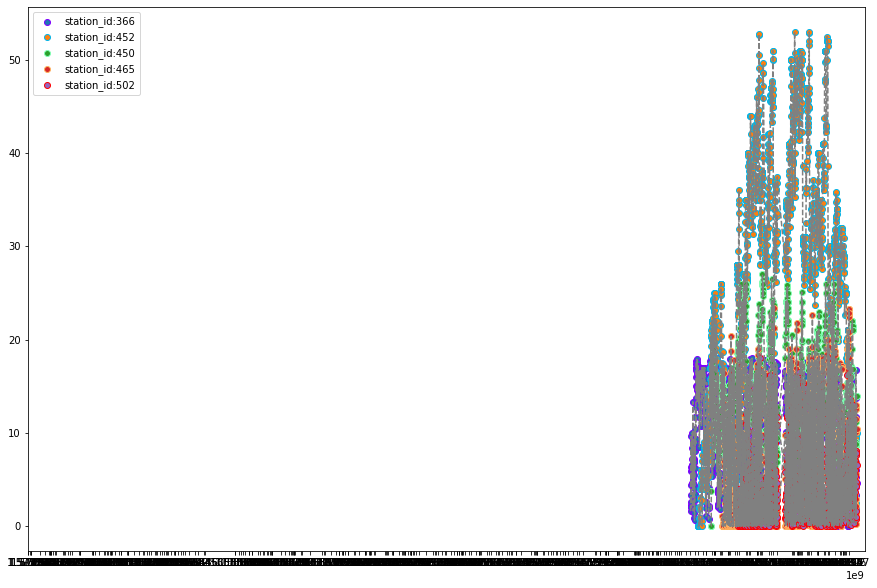

In [21]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.84 s, sys: 194 ms, total: 2.04 s
Wall time: 9.82 s


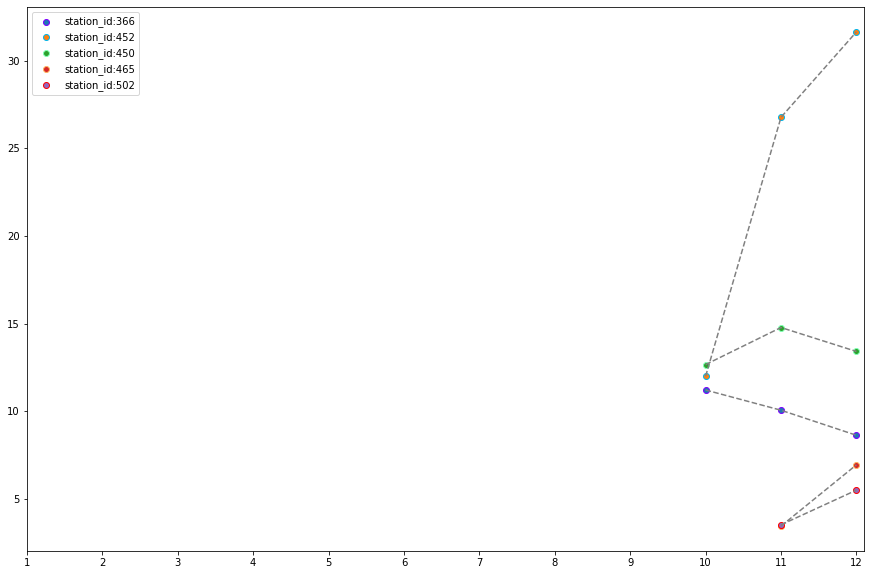

In [22]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.48 s, sys: 216 ms, total: 1.7 s
Wall time: 9.76 s


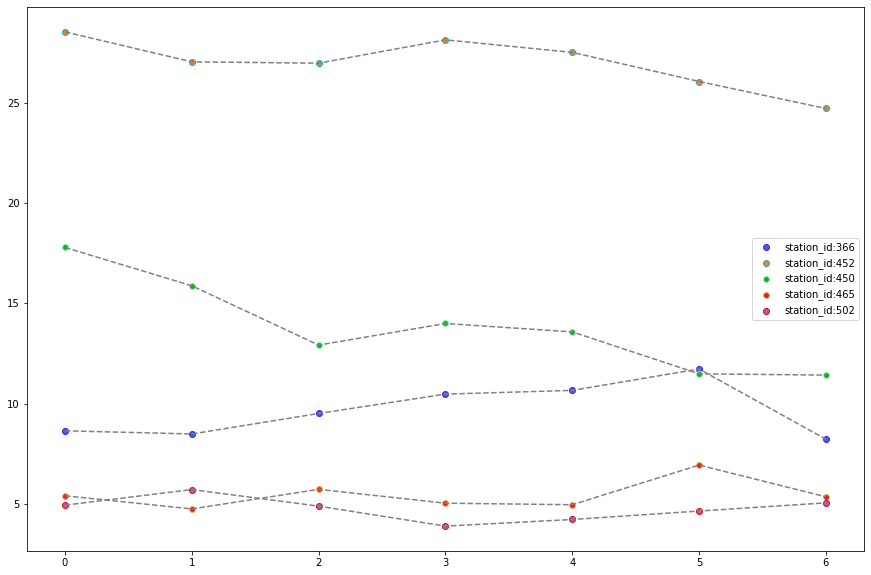

In [23]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.64 s, sys: 186 ms, total: 1.82 s
Wall time: 10.1 s


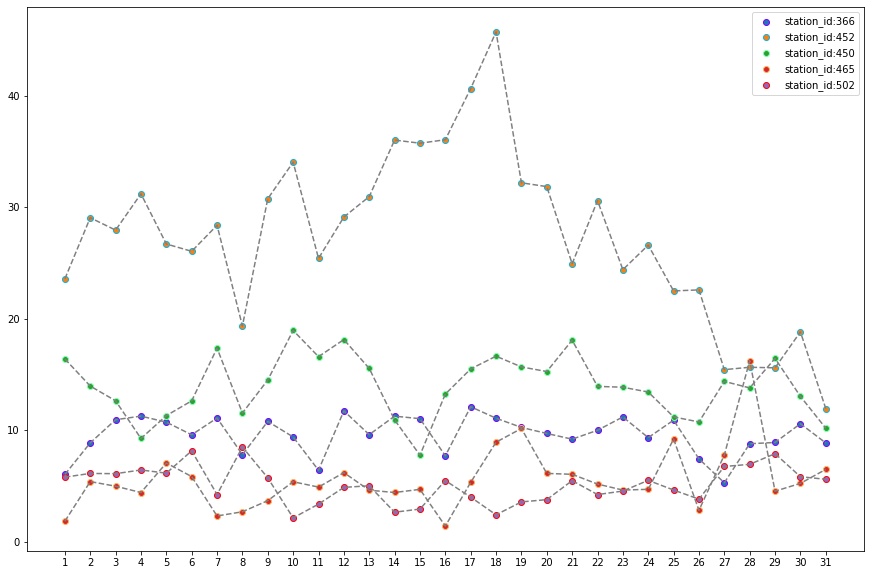

In [24]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 696, 'mean': 696.0, 'median': 696.0, 'std': nan, 'min': 696}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 744, 'mean': 744.0, 'median': 744.0, 'std': nan, 'min': 744}


  0%|          | 0/1 [00:00<?, ?it/s]

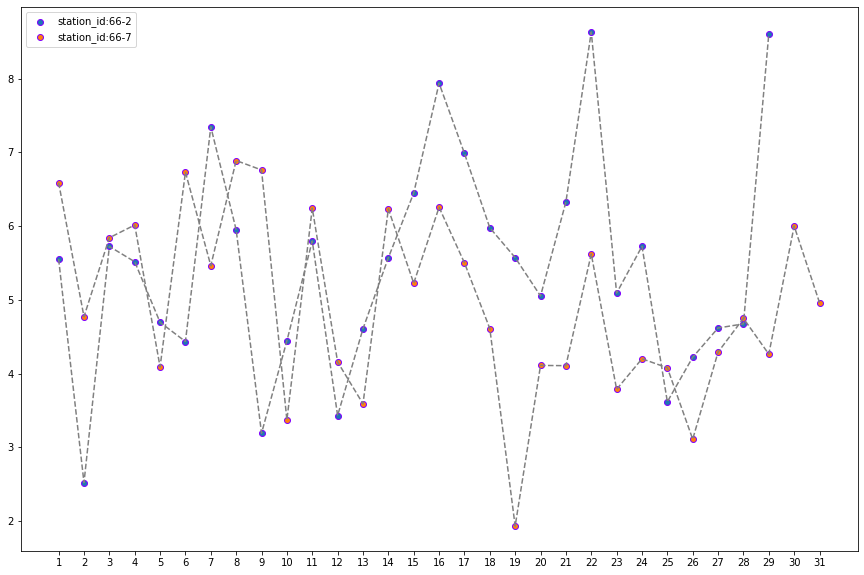

CPU times: user 1.22 s, sys: 170 ms, total: 1.39 s
Wall time: 6.84 s


In [25]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 696, 'mean': 696.0, 'median': 696.0, 'std': nan, 'min': 696}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 744, 'mean': 744.0, 'median': 744.0, 'std': nan, 'min': 744}


  0%|          | 0/1 [00:00<?, ?it/s]

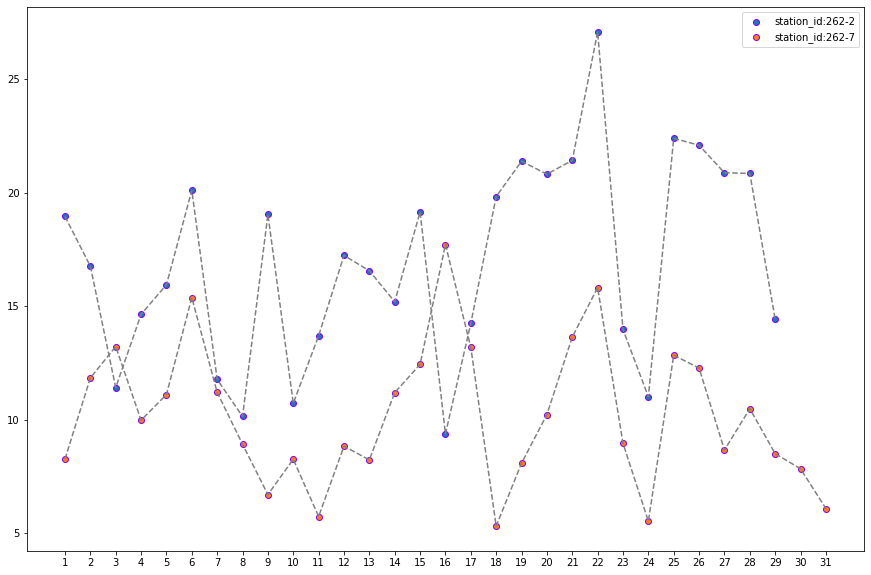

CPU times: user 1.2 s, sys: 191 ms, total: 1.39 s
Wall time: 6.62 s


In [26]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.84 s, sys: 265 ms, total: 2.11 s
Wall time: 10.3 s


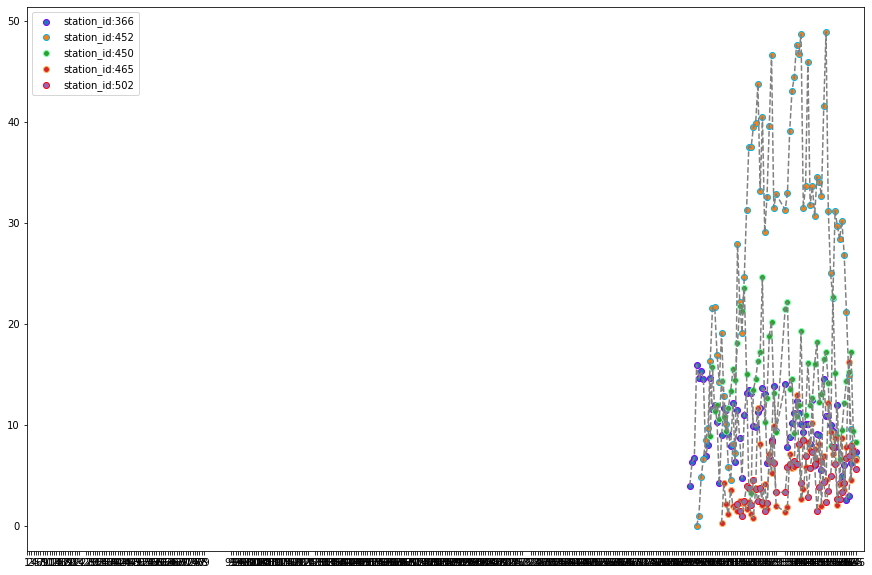

In [27]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.62 s, sys: 154 ms, total: 1.78 s
Wall time: 10 s


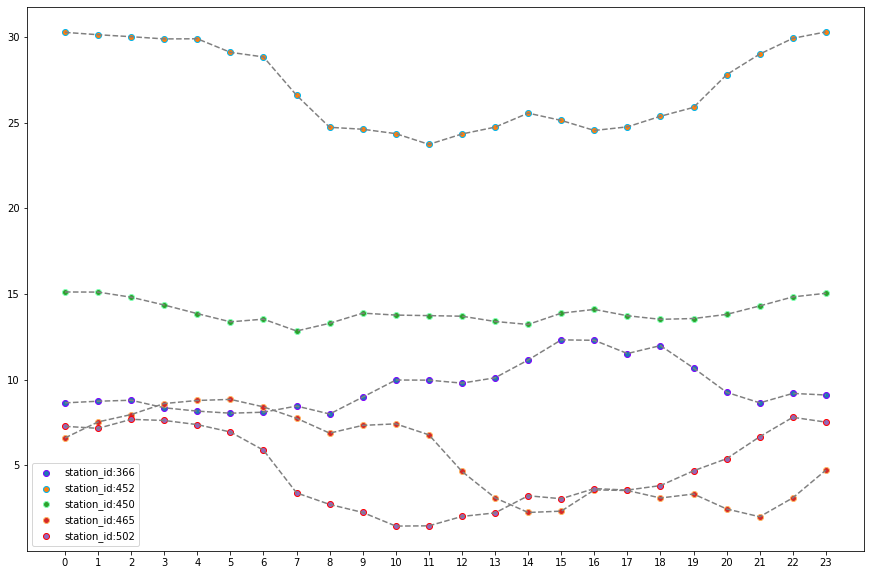

In [28]:
%%time

scatter_columns(data[config_year.year], 'hour', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 23.997938144329897, 'median': 24.0, 'std': 0.04540766091864998, 'min': 23}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.4 s, sys: 154 ms, total: 1.55 s
Wall time: 9.5 s


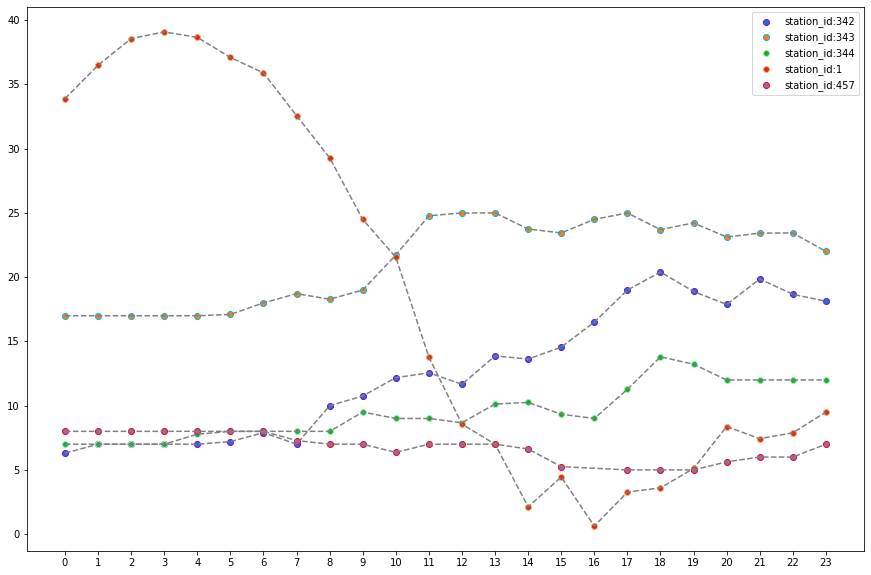

In [29]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 22.063084112149532, 'median': 24.0, 'std': 5.166840936869768, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.28 s, sys: 232 ms, total: 1.51 s
Wall time: 9.44 s


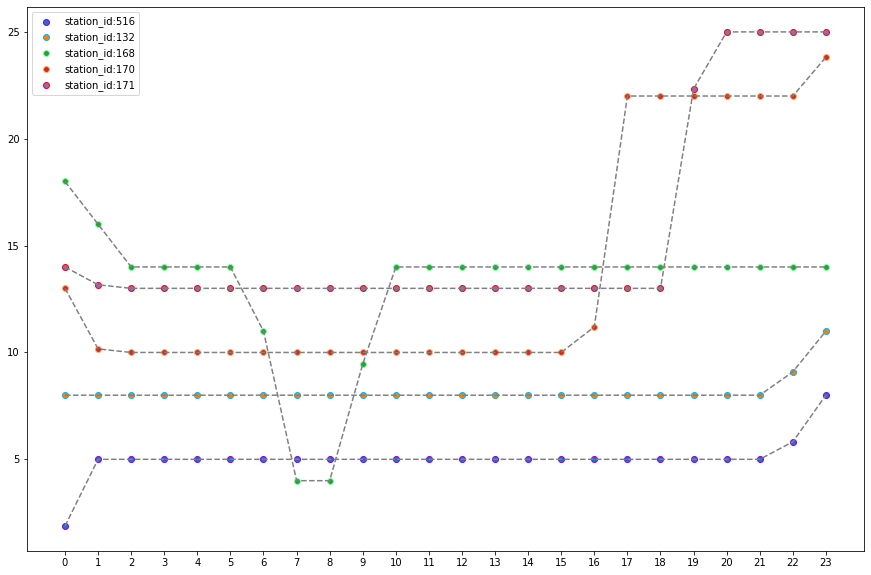

In [30]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 1092, 'mean': 1092.0, 'median': 1092.0, 'std': nan, 'min': 1092}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1080, 'mean': 1080.0, 'median': 1080.0, 'std': nan, 'min': 1080}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1105, 'mean': 1105.0, 'median': 1105.0, 'std': nan, 'min': 1105}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1125, 'mean': 1125.0, 'median': 1125.0, 'std': nan, 'min': 1125}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1064, 'mean': 1064.0, 'median': 1064.0, 'std': nan, 'min': 1064}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1044, 'mean': 1044.0, 'median': 1044.0, 'std': nan, 'min': 1044}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1055, 'mean': 1055.0, 'median': 1055.0, 'std': nan, 'min': 1055}


  0%|          | 0/1 [00:00<?, ?it/s]

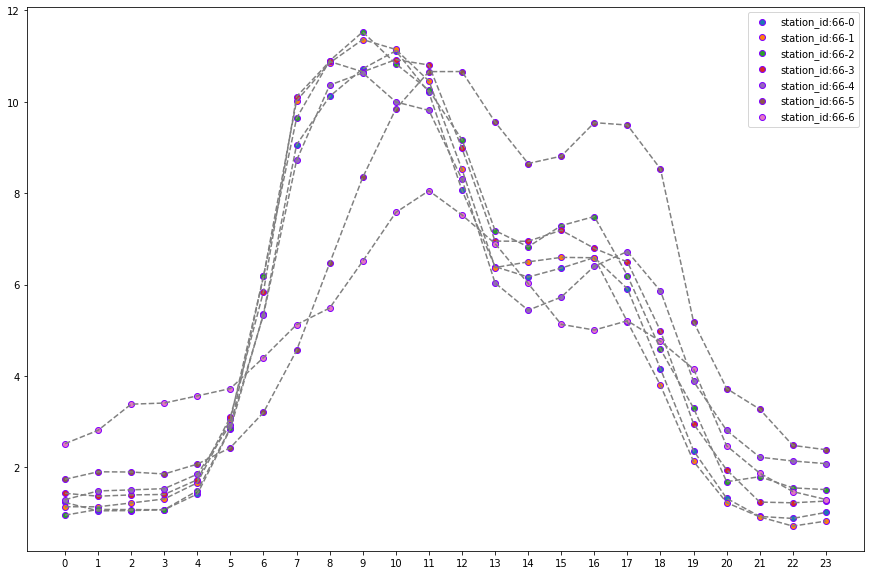

CPU times: user 3.14 s, sys: 562 ms, total: 3.7 s
Wall time: 21.5 s


In [31]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1096, 'mean': 1096.0, 'median': 1096.0, 'std': nan, 'min': 1096}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1080, 'mean': 1080.0, 'median': 1080.0, 'std': nan, 'min': 1080}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1084, 'mean': 1084.0, 'median': 1084.0, 'std': nan, 'min': 1084}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1101, 'mean': 1101.0, 'median': 1101.0, 'std': nan, 'min': 1101}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1040, 'mean': 1040.0, 'median': 1040.0, 'std': nan, 'min': 1040}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1040, 'mean': 1040.0, 'median': 1040.0, 'std': nan, 'min': 1040}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1055, 'mean': 1055.0, 'median': 1055.0, 'std': nan, 'min': 1055}


  0%|          | 0/1 [00:00<?, ?it/s]

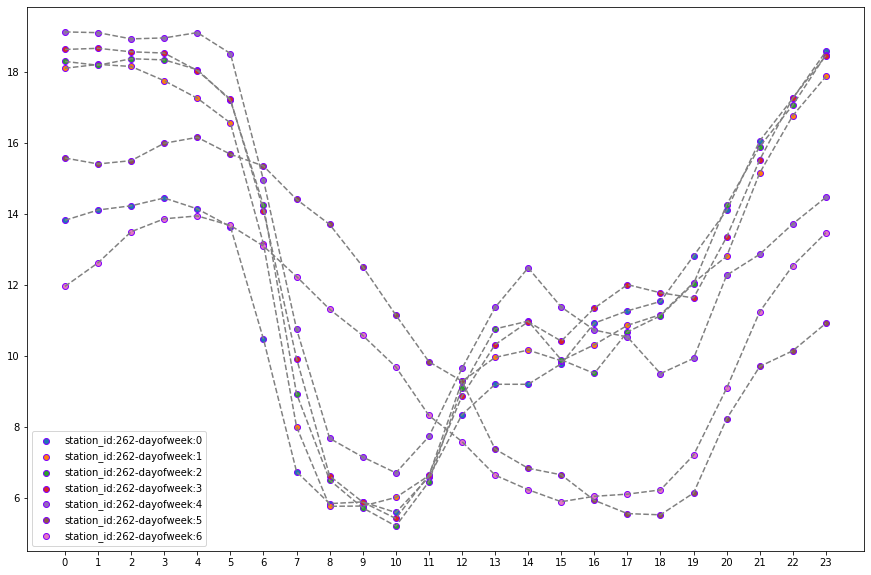

CPU times: user 3.6 s, sys: 370 ms, total: 3.97 s
Wall time: 21.8 s


In [32]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

## 2020 is_charging_station

In [33]:
%%time

print(stats.describe(data[config_year.year].is_charging_station))
data[config_year.year].is_charging_station.describe().compute()

DescribeResult(nobs=3569038, minmax=(0, 1), mean=0.999998318874722, variance=1.681122922863608e-06, skewness=-771.2565504864981, kurtosis=594834.6666683417)
CPU times: user 759 ms, sys: 67.2 ms, total: 826 ms
Wall time: 3.65 s


count    3.569038e+06
mean     9.999983e-01
std      1.296581e-03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_charging_station, dtype: float64

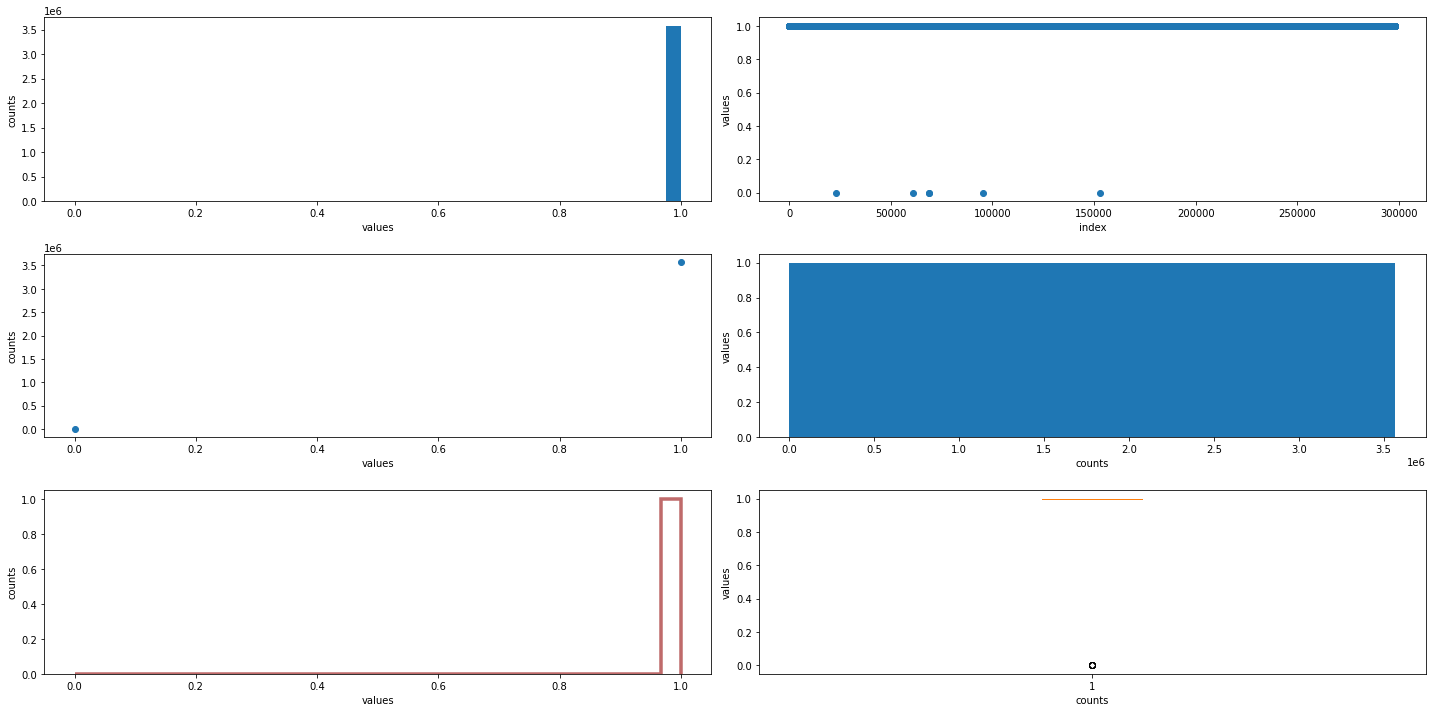

CPU times: user 6.88 s, sys: 308 ms, total: 7.19 s
Wall time: 8.33 s


In [34]:
%%time

show_counts(data[config_year.year].is_charging_station.compute())

## 2020 status

In [35]:
%%time

print(stats.describe(data[config_year.year].status))
data[config_year.year].status.describe().compute()

DescribeResult(nobs=3569038, minmax=(0, 3), mean=0.010720535897908624, variance=0.02056459791688184, skewness=13.853489805107408, kurtosis=196.0642796768741)
CPU times: user 758 ms, sys: 134 ms, total: 893 ms
Wall time: 4.38 s


count    3.569038e+06
mean     1.072054e-02
std      1.434036e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: status, dtype: float64

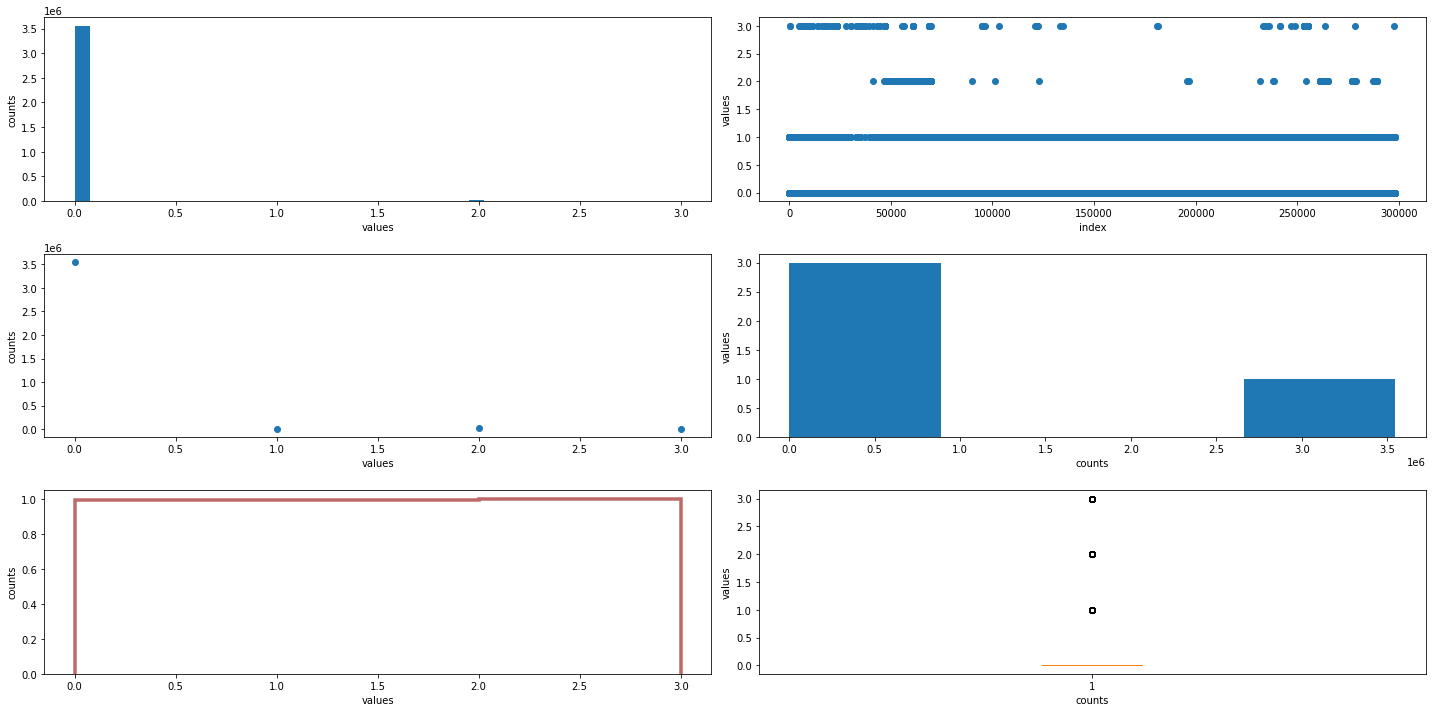

CPU times: user 6.48 s, sys: 392 ms, total: 6.87 s
Wall time: 7.99 s


In [36]:
%%time

show_counts(data[config_year.year].status.compute())

## 2020 is_installed

In [37]:
%%time

print(stats.describe(data[config_year.year].is_installed))
data[config_year.year].is_installed.describe().compute()

DescribeResult(nobs=3569038, minmax=(0, 1), mean=0.9998447760993299, variance=0.00015519984969587807, skewness=-80.24529278689072, kurtosis=6437.307014453825)
CPU times: user 616 ms, sys: 0 ns, total: 616 ms
Wall time: 3.05 s


count    3.569038e+06
mean     9.998448e-01
std      1.245792e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_installed, dtype: float64

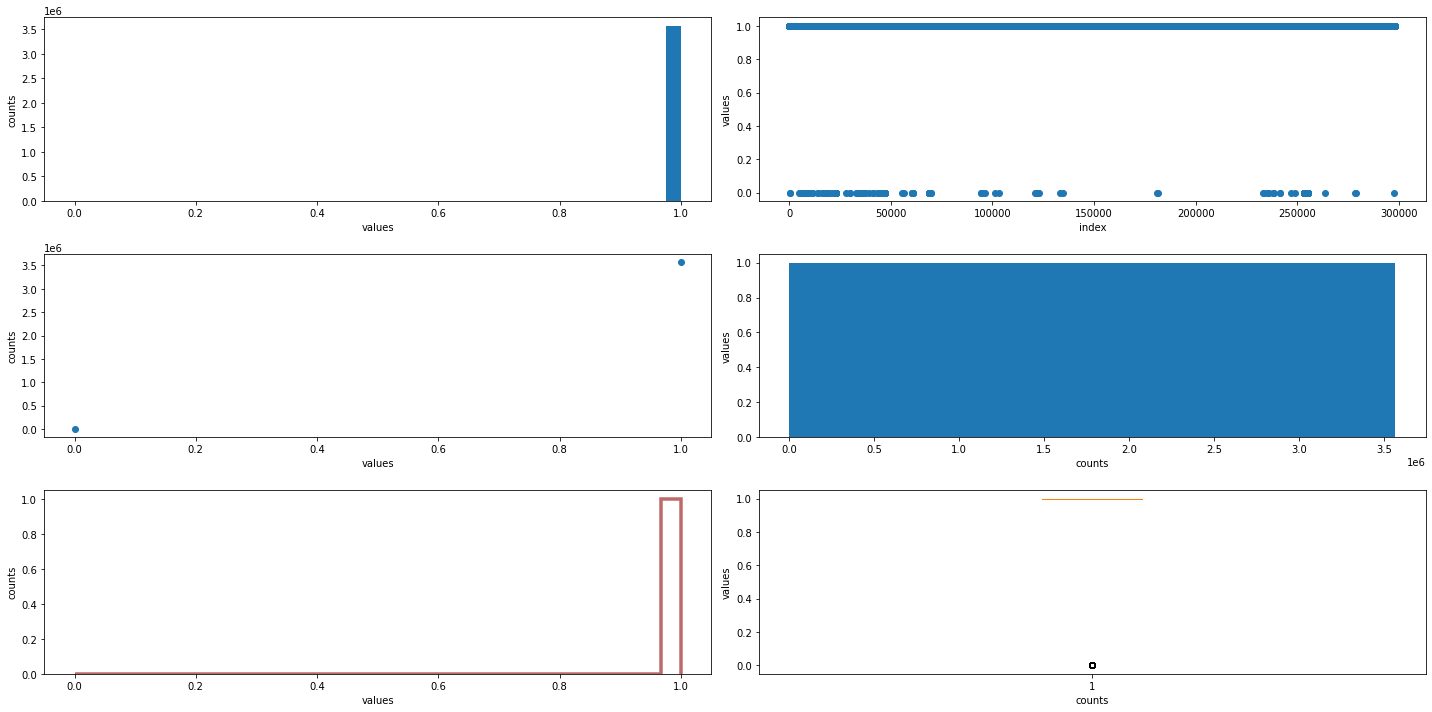

CPU times: user 6.68 s, sys: 303 ms, total: 6.99 s
Wall time: 7.98 s


In [38]:
%%time

show_counts(data[config_year.year].is_installed.compute())

## 2020 is_renting

In [39]:
%%time

print(stats.describe(data[config_year.year].is_renting))
data[config_year.year].is_renting.describe().compute()

DescribeResult(nobs=3569038, minmax=(0, 1), mean=0.993967842314932, variance=0.005995772438671325, skewness=-12.75869227064489, kurtosis=160.78422845701354)
CPU times: user 613 ms, sys: 7.77 ms, total: 621 ms
Wall time: 3.09 s


count    3.569038e+06
mean     9.939678e-01
std      7.743237e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_renting, dtype: float64

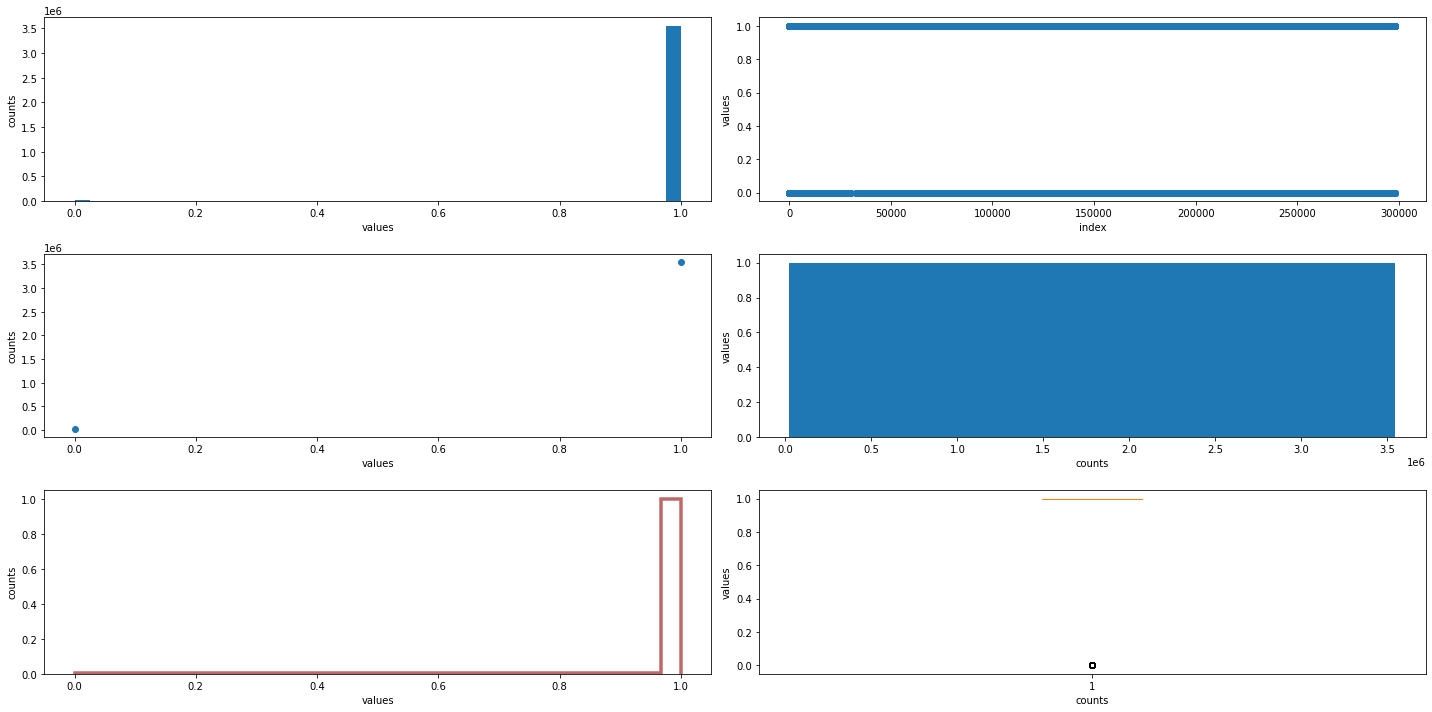

CPU times: user 6.51 s, sys: 236 ms, total: 6.75 s
Wall time: 7.7 s


In [40]:
%%time

show_counts(data[config_year.year].is_renting.compute())

## 2020 is_returning

In [41]:
%%time

print(stats.describe(data[config_year.year].is_returning))
data[config_year.year].is_returning.describe().compute()

DescribeResult(nobs=3569038, minmax=(0, 1), mean=0.994088883334949, variance=0.00587617701125469, skewness=-12.891032528305777, kurtosis=164.17871964583674)
CPU times: user 650 ms, sys: 66.4 ms, total: 716 ms
Wall time: 3.3 s


count    3.569038e+06
mean     9.940889e-01
std      7.665623e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_returning, dtype: float64

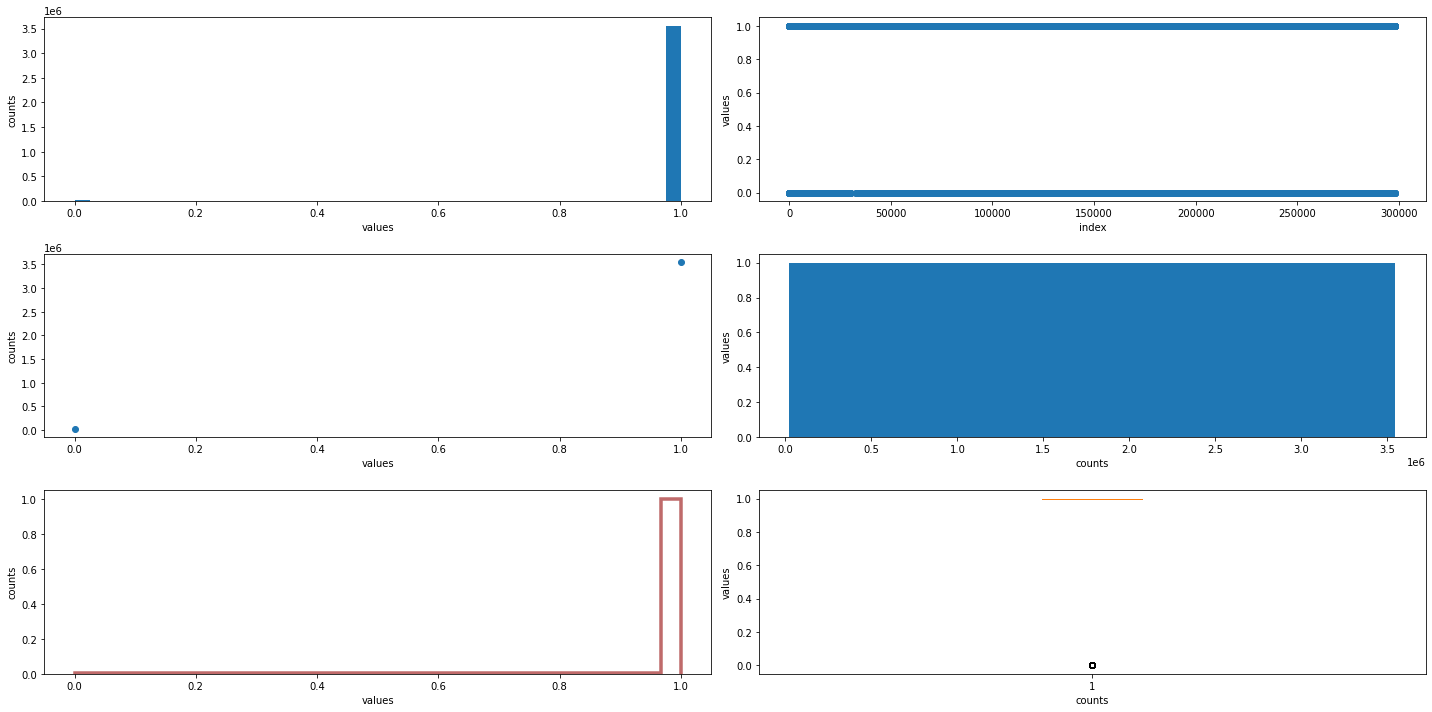

CPU times: user 6.5 s, sys: 338 ms, total: 6.84 s
Wall time: 7.87 s


In [42]:
%%time

show_counts(data[config_year.year].is_returning.compute())

## 2020 ctx0

In [43]:
%%time

print(stats.describe(data[config_year.year].ctx0))
data[config_year.year].ctx0.describe().compute()

DescribeResult(nobs=3569038, minmax=(0.0, 1.0), mean=0.5761860426403744, variance=0.07847590540041817, skewness=-0.35503054120586597, kurtosis=-0.9587753383790174)
CPU times: user 567 ms, sys: 71.1 ms, total: 638 ms
Wall time: 3.17 s


count    3.569038e+06
mean     5.761860e-01
std      2.801355e-01
min      0.000000e+00
25%      3.703704e-01
50%      6.064815e-01
75%      8.214286e-01
max      1.000000e+00
Name: ctx0, dtype: float64

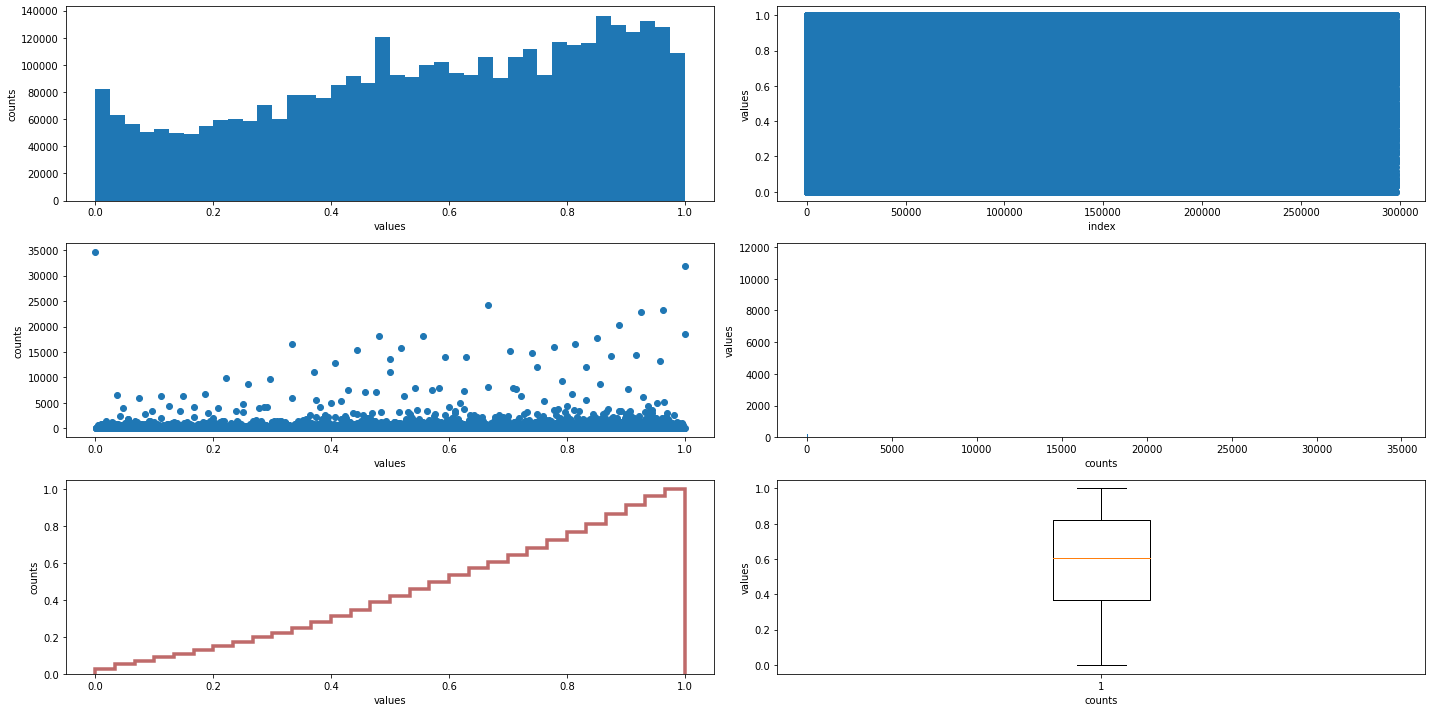

CPU times: user 2min 20s, sys: 17 s, total: 2min 37s
Wall time: 2min 33s


In [44]:
%%time

show_counts(data[config_year.year].ctx0.compute())

327
value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 846 ms, sys: 30.8 ms, total: 876 ms
Wall time: 3.33 s


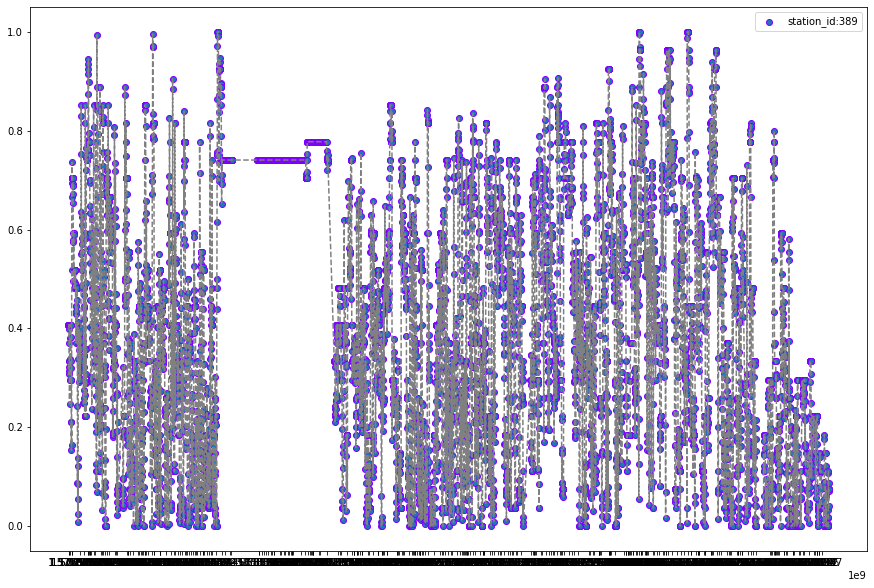

In [45]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=1
)


value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.24 s, sys: 155 ms, total: 1.39 s
Wall time: 8.86 s


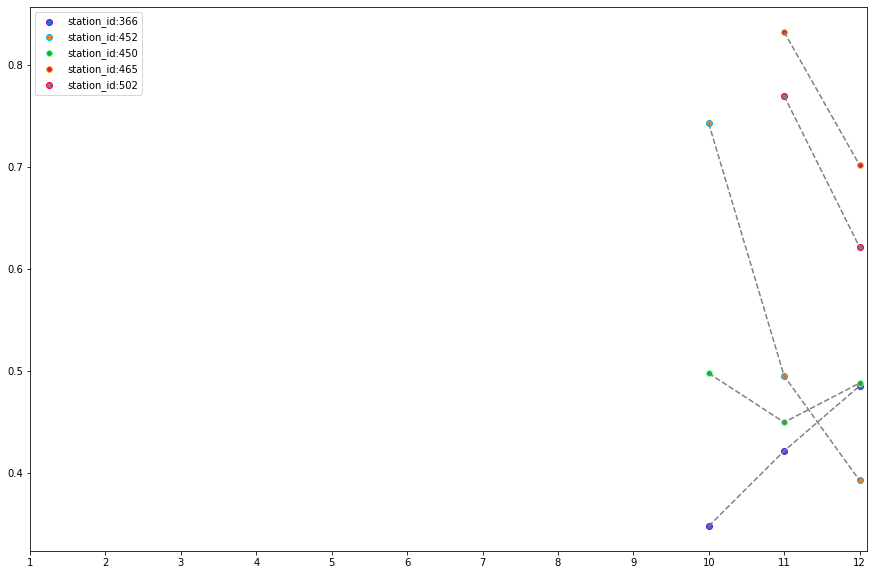

In [46]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.21 s, sys: 140 ms, total: 1.35 s
Wall time: 8.54 s


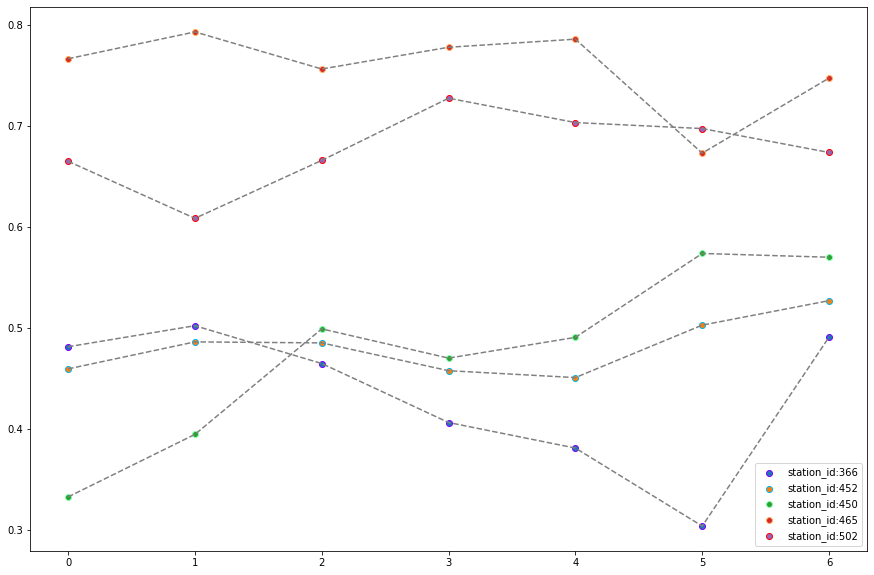

In [47]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.31 s, sys: 150 ms, total: 1.46 s
Wall time: 9.02 s


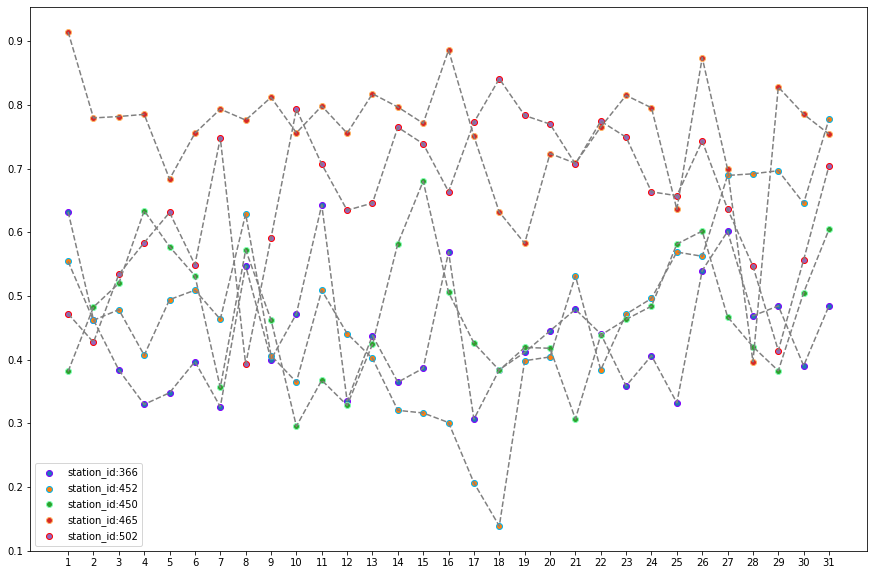

In [48]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 696, 'mean': 696.0, 'median': 696.0, 'std': nan, 'min': 696}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 744, 'mean': 744.0, 'median': 744.0, 'std': nan, 'min': 744}


  0%|          | 0/1 [00:00<?, ?it/s]

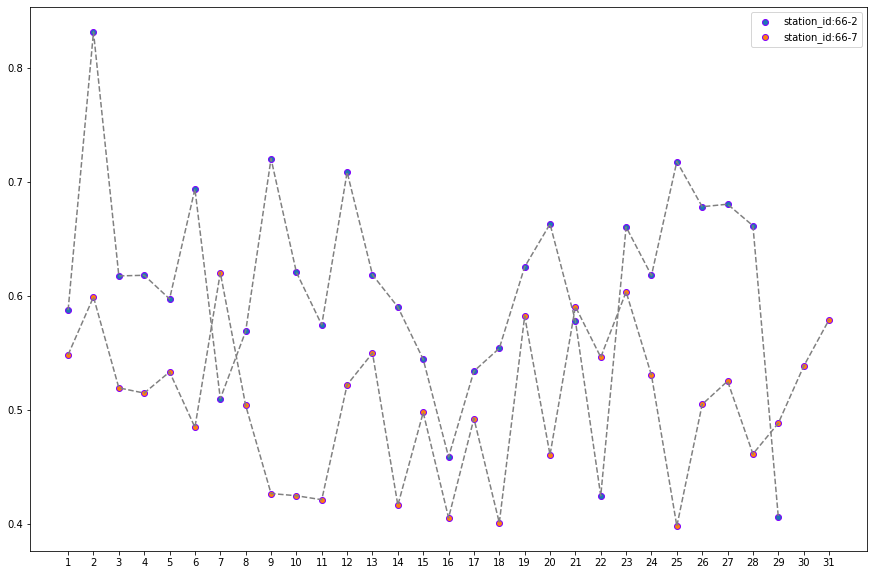

CPU times: user 1.2 s, sys: 156 ms, total: 1.35 s
Wall time: 6.48 s


In [49]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 696, 'mean': 696.0, 'median': 696.0, 'std': nan, 'min': 696}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 744, 'mean': 744.0, 'median': 744.0, 'std': nan, 'min': 744}


  0%|          | 0/1 [00:00<?, ?it/s]

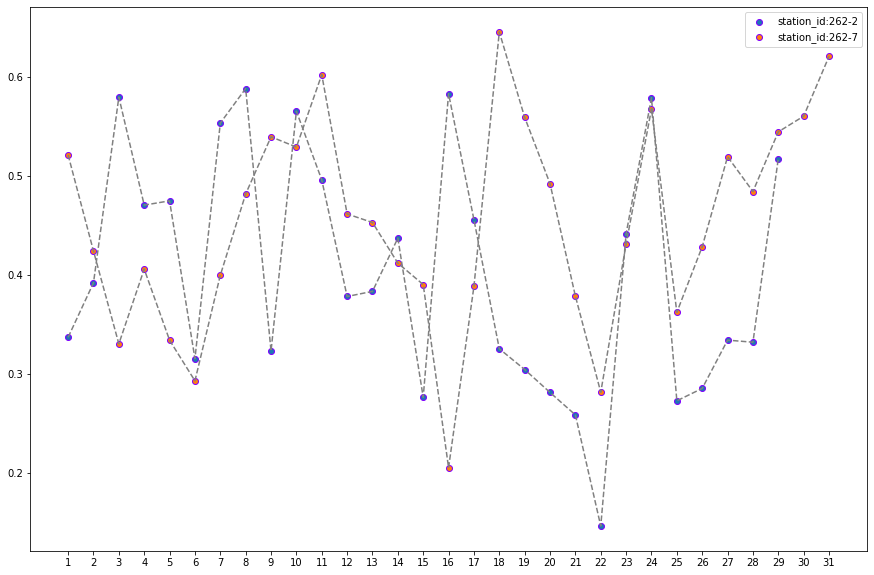

CPU times: user 1.35 s, sys: 185 ms, total: 1.54 s
Wall time: 7.13 s


In [50]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.85 s, sys: 158 ms, total: 2.01 s
Wall time: 9.85 s


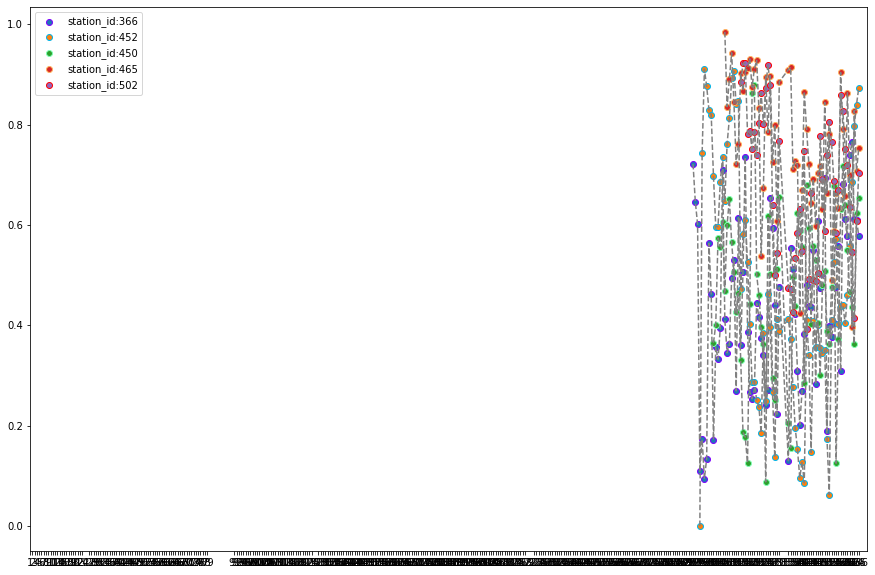

In [51]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8160, 'mean': 7053.434782608696, 'median': 7576.0, 'std': 1234.6071346490705, 'min': 1144}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.83 s, sys: 199 ms, total: 2.03 s
Wall time: 10.9 s


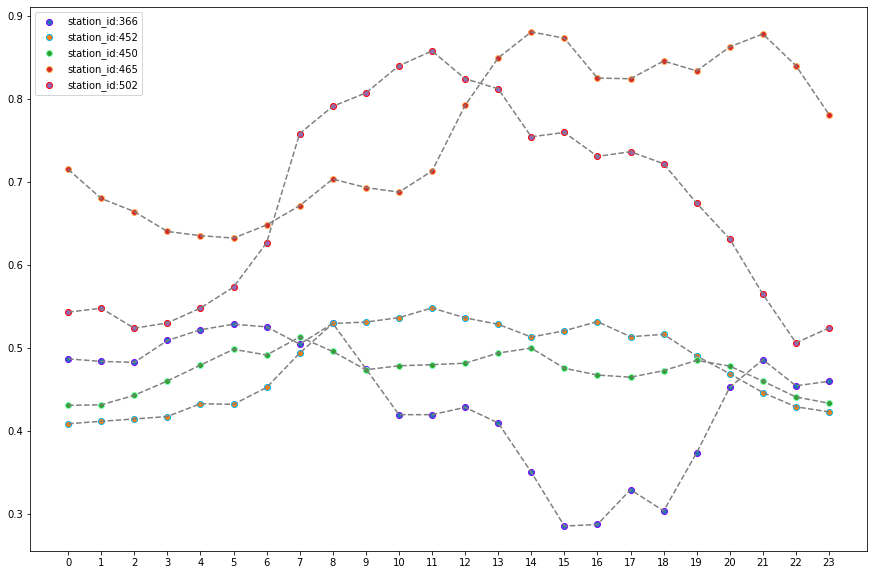

In [52]:
%%time

scatter_columns(data[config_year.year], 'hour', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 23.997938144329897, 'median': 24.0, 'std': 0.04540766091864998, 'min': 23}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.47 s, sys: 152 ms, total: 1.63 s
Wall time: 9.4 s


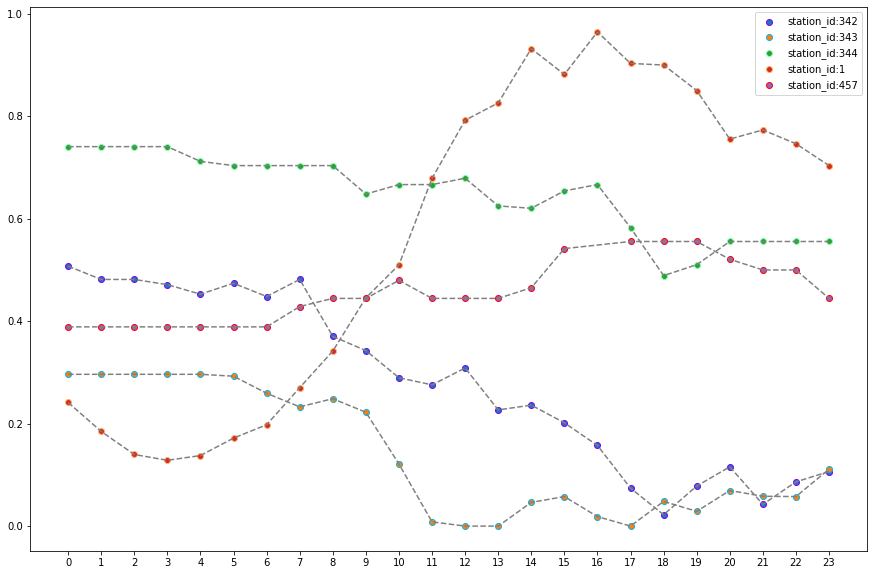

In [53]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 22.063084112149532, 'median': 24.0, 'std': 5.166840936869768, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.37 s, sys: 155 ms, total: 1.53 s
Wall time: 9.21 s


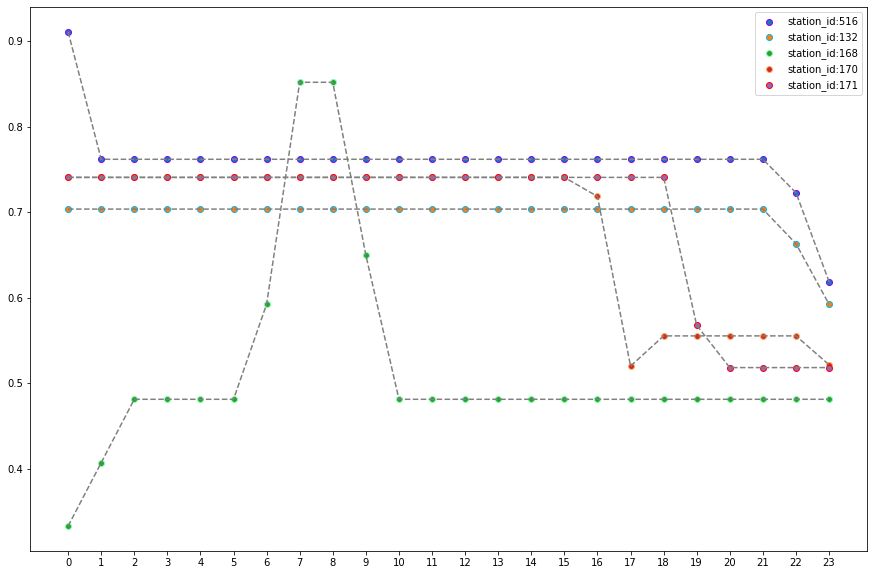

In [54]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 1092, 'mean': 1092.0, 'median': 1092.0, 'std': nan, 'min': 1092}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1080, 'mean': 1080.0, 'median': 1080.0, 'std': nan, 'min': 1080}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1105, 'mean': 1105.0, 'median': 1105.0, 'std': nan, 'min': 1105}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1125, 'mean': 1125.0, 'median': 1125.0, 'std': nan, 'min': 1125}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1064, 'mean': 1064.0, 'median': 1064.0, 'std': nan, 'min': 1064}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1044, 'mean': 1044.0, 'median': 1044.0, 'std': nan, 'min': 1044}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1055, 'mean': 1055.0, 'median': 1055.0, 'std': nan, 'min': 1055}


  0%|          | 0/1 [00:00<?, ?it/s]

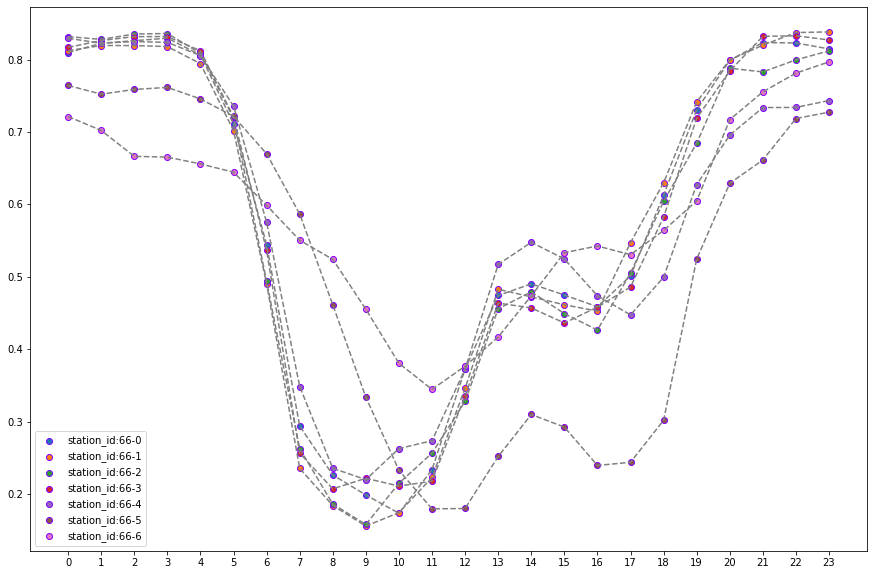

CPU times: user 3.86 s, sys: 422 ms, total: 4.28 s
Wall time: 22.7 s


In [55]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1096, 'mean': 1096.0, 'median': 1096.0, 'std': nan, 'min': 1096}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1080, 'mean': 1080.0, 'median': 1080.0, 'std': nan, 'min': 1080}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1084, 'mean': 1084.0, 'median': 1084.0, 'std': nan, 'min': 1084}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1101, 'mean': 1101.0, 'median': 1101.0, 'std': nan, 'min': 1101}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1040, 'mean': 1040.0, 'median': 1040.0, 'std': nan, 'min': 1040}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1040, 'mean': 1040.0, 'median': 1040.0, 'std': nan, 'min': 1040}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1055, 'mean': 1055.0, 'median': 1055.0, 'std': nan, 'min': 1055}


  0%|          | 0/1 [00:00<?, ?it/s]

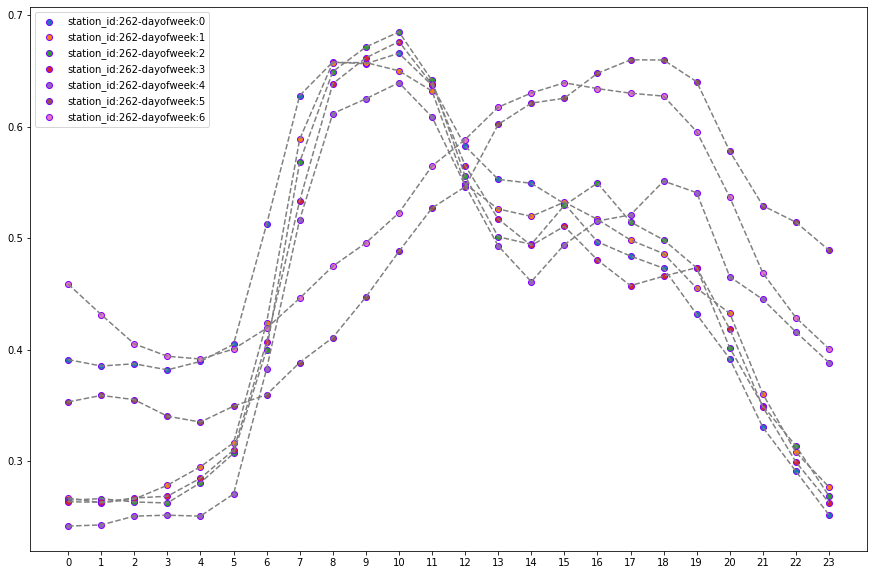

CPU times: user 3.7 s, sys: 437 ms, total: 4.14 s
Wall time: 22.7 s


In [56]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()